In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import osmnx as ox
import folium
from IPython.display import display

# Biking data preparation

We have a dataset for each year between 2016 and 2022, counting the number of bikes per hour at specific locations in Paris. We downloaded this data from the official [Paris Data](https://parisdata.opendatasoft.com/explore/dataset/comptage-velo-donnees-compteurs/dataviz/?disjunctive.id_compteur&disjunctive.nom_compteur&disjunctive.id&disjunctive.name) website.

Let us have a first look at the dataset:

In [4]:
df2022 = pd.read_csv('2022_comptage-velo-donnees-sites-comptage.csv',sep=';')
df2022

,Identifiant du point de comptage,Nom du point de comptage,Comptage horaire,Date et heure de comptage,Lien vers photo du point de comptage,Coordonnées géographiques
0,100003096,97 avenue Denfert Rochereau,0,2022-01-01T00:00:00,https://filer.eco-counter-tools.com/file/10/6d...,"48.83504,2.33314"
1,100003096,97 avenue Denfert Rochereau,0,2022-01-01T00:15:00,https://filer.eco-counter-tools.com/file/10/6d...,"48.83504,2.33314"
2,100003096,97 avenue Denfert Rochereau,0,2022-01-01T00:30:00,https://filer.eco-counter-tools.com/file/10/6d...,"48.83504,2.33314"
3,100003096,97 avenue Denfert Rochereau,0,2022-01-01T00:45:00,https://filer.eco-counter-tools.com/file/10/6d...,"48.83504,2.33314"
4,100003096,97 avenue Denfert Rochereau,13,2022-01-01T01:00:00,https://filer.eco-counter-tools.com/file/10/6d...,"48.83504,2.33314"
...,...,...,...,...,...,...
5886715,100047541,Pont National,0,2022-12-31T22:45:00,https://filer.eco-counter-tools.com/file/2a/79...,"48.82639,2.38448"
5886716,100047541,Pont National,0,2022-12-31T23:00:00,https://filer.eco-counter-tools.com/file/2a/79...,"48.82639,2.38448"
5886717,100047541,Pont National,0,2022-12-31T23:15:00,https://filer.eco-counter-tools.com/file/2a/79...,"48.82639,2.38448"
5886718,100047541,Pont National,0,2022-12-31T23:30:00,https://filer.eco-counter-tools.com/file/2a/79...,"48.82639,2.38448"


The columns are not the different counting sites as we would hope. We can start by discarding the unecessary columns and check that each counting site has the same number of observations.

In [32]:
#df2022.drop(['Identifiant du point de comptage','Lien vers photo du point de comptage'], axis = 1, inplace = True)
df2022['Coordonnées géographiques'].value_counts()

48.84837,2.27596      350400
48.85013,2.35423      210240
48.860528,2.388364    175200
48.85735,2.35211      140160
48.83848,2.37587      140160
                       ...  
48.86279,2.31055       35040
48.86382,2.32006       35040
48.86281,2.31037       35040
48.82108,2.32537       35040
48.89683,2.34521       35040
Name: Coordonnées géographiques, Length: 73, dtype: int64

We don't have the same number of observation for each station! The dataset is supposed to have a value for each station and each 15 minutes, yelding $4\times24\times365=35040$ observations. This is indeed what we have for the station with the least number of observations. This indicates that the other stations have duplicates. Let us quickly check this:

In [34]:
#check that both stations have records for the same points in time
a=df2022[df2022['Coordonnées géographiques'] == "48.84837,2.27596"]["Date et heure de comptage"].unique()
b=df2022[df2022['Coordonnées géographiques'] == "48.89683,2.34521"]["Date et heure de comptage"].unique()
print(all(a==b))

#display the duplicates
duplicates = df2022[df2022['Coordonnées géographiques'] == "48.84837,2.27596"].duplicated(subset=["Date et heure de comptage"])
df2022[df2022['Coordonnées géographiques'] == "48.84837,2.27596"][duplicates].sort_values(by='Date et heure de comptage')

True


,Nom du point de comptage,Comptage horaire,Date et heure de comptage,Coordonnées géographiques
2592960,Voie Georges Pompidou,5,2022-01-01T00:00:00,"48.84837,2.27596"
5291040,Voie Georges Pompidou,0,2022-01-01T00:00:00,"48.84837,2.27596"
4344960,Voie Georges Pompidou,0,2022-01-01T00:00:00,"48.84837,2.27596"
5220960,Voie Georges Pompidou,0,2022-01-01T00:00:00,"48.84837,2.27596"
5150880,Voie Georges Pompidou,0,2022-01-01T00:00:00,"48.84837,2.27596"
...,...,...,...,...
5115839,Voie Georges Pompidou,0,2022-12-31T23:45:00,"48.84837,2.27596"
5291039,Voie Georges Pompidou,0,2022-12-31T23:45:00,"48.84837,2.27596"
2627999,Voie Georges Pompidou,0,2022-12-31T23:45:00,"48.84837,2.27596"
3574079,Voie Georges Pompidou,0,2022-12-31T23:45:00,"48.84837,2.27596"


In [30]:
df2022_cleaned = df2022.groupby(['Coordonnées géographiques', 'Date et heure de comptage'])['Comptage horaire'].mean().reset_index()
df2022_cleaned

,Coordonnées géographiques,Date et heure de comptage,Comptage horaire
0,"48.82009,2.3588",2022-01-01T00:00:00,0.0
1,"48.82009,2.3588",2022-01-01T00:15:00,1.0
2,"48.82009,2.3588",2022-01-01T00:30:00,0.0
3,"48.82009,2.3588",2022-01-01T00:45:00,2.0
4,"48.82009,2.3588",2022-01-01T01:00:00,2.0
...,...,...,...
2557915,"48.89696,2.34538",2022-12-31T22:45:00,0.0
2557916,"48.89696,2.34538",2022-12-31T23:00:00,0.0
2557917,"48.89696,2.34538",2022-12-31T23:15:00,0.0
2557918,"48.89696,2.34538",2022-12-31T23:30:00,0.0


In [35]:
df2022_cleaned['Coordonnées géographiques'].value_counts()

48.82009,2.3588       35040
48.860852,2.372279    35040
48.86999,2.30722      35040
48.86502,2.35387      35040
48.86485,2.40966      35040
                      ...  
48.846099,2.375456    35040
48.843435,2.383378    35040
48.84223,2.36811      35040
48.84222,2.30102      35040
48.89696,2.34538      35040
Name: Coordonnées géographiques, Length: 73, dtype: int64

We took care of the duplicates. Let us now visualize the localization of these counting sites.

In [58]:
Paris_map = folium.Map(location = [48.83504, 2.33314])
for coord in df2022_cleaned['Coordonnées géographiques'].unique():
    try:
        lat,long = map(float,coord.split(','))
    except:
        print(coord)
        raise ValueError
    Paris_map.add_child(folium.Marker(location = [lat, long]))
Paris_map

We cannot just take the mean of the counters as it would be biased by their location. (further develop this idea)

In [59]:
split_dfs = dict()
for group_name, group_df in df2022_cleaned.groupby('Coordonnées géographiques'):
    s1=group_df['Comptage horaire'].sum()
    if(s1!=0):
        split_dfs[group_name] = group_df.copy()
    print(s1)

429788.0
423904.0
21452.0
247840.75
8029.5
688508.0
179821.25
111603.0
168154.0
343043.0
65618.0
232314.0
231402.5
595898.0
187283.5
250584.5
221471.5
577619.0
152341.25
405588.75
373342.0
391174.0
198831.25
591541.0
542040.0
199912.0
437895.5
100391.40000000001
331644.3333333334
563715.0
89000.0
304920.0
140474.5
773231.75
254448.8
316756.0
1226964.0
946982.0
0.0
1268808.0
1350036.0
535480.0
282001.0
230899.0
456100.75
621385.5
921111.0
1096055.5
808860.0
0.0
399208.0
156877.75
490536.25
829253.0
625927.0
286817.0
237442.0
1597979.0
1612161.0
378292.0
10.5
173797.0
266031.0
15945.0
613875.0
713542.0
185852.25
208933.0
461002.75
16041.75
0.0
620393.0
0.0


In [60]:
selected_points = []
for coord in split_dfs.keys():
    lat,long = map(float, coord.split(','))
    if selected_points == []:
        selected_points.append([coord,lat,long,1])
    else:
        merged = False
        for i,(point_coord,point_lat,point_long,_) in enumerate(selected_points):
            if abs(point_lat-lat)<0.015 and abs(point_long-long)<0.015:
                merged = True
                selected_points[i][3]+=1
                print('------')
                (split_dfs[coord]).reset_index(drop=True, inplace=True)
                print((split_dfs[point_coord])['Comptage horaire'][:10])
                (split_dfs[point_coord])['Comptage horaire'] = (split_dfs[point_coord])['Comptage horaire'] + (split_dfs[coord])['Comptage horaire']
                print((split_dfs[point_coord])['Comptage horaire'][:10])
                print('_____________')
        if not merged:
            (split_dfs[coord]).reset_index(drop=True, inplace=True)
            selected_points.append([coord,lat,long,1])
print(selected_points)

# take the mean
for i,(point_coord,point_lat,point_long,n) in enumerate(selected_points):
    (split_dfs[point_coord])['Comptage horaire'] = (split_dfs[point_coord])['Comptage horaire']/n

------
0    0.0
1    1.0
2    0.0
3    2.0
4    2.0
5    0.0
6    0.0
7    4.0
8    3.0
9    2.0
Name: Comptage horaire, dtype: float64
0     0.0
1     4.0
2     0.0
3     8.0
4     4.0
5     0.0
6     5.0
7    15.0
8     9.0
9     6.0
Name: Comptage horaire, dtype: float64
_____________
------
0    0.0
1    0.0
2    0.0
3    0.0
4    1.0
5    1.0
6    0.0
7    0.5
8    0.5
9    0.5
Name: Comptage horaire, dtype: float64
0    1.0
1    1.0
2    2.0
3    2.0
4    1.0
5    8.0
6    2.0
7    4.5
8    4.5
9    7.5
Name: Comptage horaire, dtype: float64
_____________
------
0    1.0
1    1.0
2    2.0
3    2.0
4    1.0
5    8.0
6    2.0
7    4.5
8    4.5
9    7.5
Name: Comptage horaire, dtype: float64
0     1.75
1     1.50
2     2.50
3     3.50
4     1.75
5     8.00
6     3.25
7     4.50
8     5.25
9    10.25
Name: Comptage horaire, dtype: float64
_____________
------
0     0.0
1     4.0
2     0.0
3     8.0
4     4.0
5     0.0
6     5.0
7    15.0
8     9.0
9     6.0
Name: Comptage horaire, dt

In [61]:
grouped_Paris_map = folium.Map(location = [48.83504, 2.33314])
for coord,lat,long,_ in selected_points:
    grouped_Paris_map.add_child(folium.Marker(location = [lat, long]))
grouped_Paris_map

We get a faiRly homogeneous distrubution of counters!

In [62]:
for (point_coord,point_lat,point_long,n) in selected_points:
    (split_dfs[point_coord])['date'] = (split_dfs[point_coord])['Date et heure de comptage'].str[:10]
    (split_dfs[point_coord]) = (split_dfs[point_coord]).groupby(by = ['date'],as_index=True).sum()
    (split_dfs[point_coord]).rename(columns={'Comptage horaire': f'Bikes at {point_coord}'},inplace=True, errors='raise')
    print(split_dfs[point_coord])

C:\Users\ssss\AppData\Local\Temp\ipykernel_10108\2736275785.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (split_dfs[point_coord]) = (split_dfs[point_coord]).groupby(by = ['date'],as_index=True).sum()
C:\Users\ssss\AppData\Local\Temp\ipykernel_10108\2736275785.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (split_dfs[point_coord]) = (split_dfs[point_coord]).groupby(by = ['date'],as_index=True).sum()
C:\Users\ssss\AppData\Local\Temp\ipykernel_10108\2736275785.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default t

            Bikes at 48.82009,2.3588
date                                
2022-01-01                    458.75
2022-01-02                    429.50
2022-01-03                    736.25
2022-01-04                    643.75
2022-01-05                    909.75
...                              ...
2022-12-27                    482.50
2022-12-28                    443.00
2022-12-29                    610.00
2022-12-30                    432.00
2022-12-31                    495.00

[365 rows x 1 columns]
            Bikes at 48.82108,2.32537
date                                 
2022-01-01                 369.333333
2022-01-02                 382.833333
2022-01-03                 499.833333
2022-01-04                 527.333333
2022-01-05                 667.833333
...                               ...
2022-12-27                 384.333333
2022-12-28                 303.166667
2022-12-29                 407.333333
2022-12-30                 296.000000
2022-12-31                 343.166667



C:\Users\ssss\AppData\Local\Temp\ipykernel_10108\2736275785.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (split_dfs[point_coord]) = (split_dfs[point_coord]).groupby(by = ['date'],as_index=True).sum()
C:\Users\ssss\AppData\Local\Temp\ipykernel_10108\2736275785.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (split_dfs[point_coord]) = (split_dfs[point_coord]).groupby(by = ['date'],as_index=True).sum()
C:\Users\ssss\AppData\Local\Temp\ipykernel_10108\2736275785.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default t

In [65]:
merged_data = split_dfs[selected_points[0][0]]  # Initialize merged_data with the first DataFrame
for i in range(1, len(selected_points)):
    print(split_dfs[selected_points[i][0]])
    merged_data = pd.merge(merged_data, split_dfs[selected_points[i][0]], how='outer', left_index=True, right_index=True)
    
merged_data

            Bikes at 48.82108,2.32537
date                                 
2022-01-01                 369.333333
2022-01-02                 382.833333
2022-01-03                 499.833333
2022-01-04                 527.333333
2022-01-05                 667.833333
...                               ...
2022-12-27                 384.333333
2022-12-28                 303.166667
2022-12-29                 407.333333
2022-12-30                 296.000000
2022-12-31                 343.166667

[365 rows x 1 columns]
            Bikes at 48.82624,2.30281
date                                 
2022-01-01                    328.125
2022-01-02                    361.625
2022-01-03                    596.250
2022-01-04                    593.500
2022-01-05                    714.375
...                               ...
2022-12-27                    157.375
2022-12-28                    129.625
2022-12-29                    170.875
2022-12-30                    107.125
2022-12-31                

,"Bikes at 48.82009,2.3588","Bikes at 48.82108,2.32537","Bikes at 48.82624,2.30281","Bikes at 48.82639,2.38448","Bikes at 48.83033052177593,2.400550837519253","Bikes at 48.83428,2.26526","Bikes at 48.84017,2.33438","Bikes at 48.84201,2.36729","Bikes at 48.84209,2.30115","Bikes at 48.843435,2.383378",...,"Bikes at 48.85735,2.35211","Bikes at 48.860528,2.388364","Bikes at 48.86077,2.37305","Bikes at 48.86179,2.32014","Bikes at 48.86485,2.40966","Bikes at 48.87474,2.29219","Bikes at 48.87756,2.35535","Bikes at 48.88529,2.32666","Bikes at 48.889046,2.374872","Bikes at 48.89594,2.35953"
date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,458.75,369.333333,328.125,349.20,178.25,303.0375,441.583333,290.916667,470.333333,426.333333,...,945.333333,1089.70,1323.25,780.550,137.25,269.00,959.30,312.50,480.05,470.500
2022-01-02,429.50,382.833333,361.625,325.35,180.50,306.1000,484.750000,303.805556,510.333333,531.333333,...,1090.000000,1227.70,1480.50,685.125,146.25,267.50,1072.90,460.50,532.80,468.625
2022-01-03,736.25,499.833333,596.250,522.00,196.00,453.8375,711.333333,469.458333,855.000000,674.000000,...,1279.666667,1883.50,2213.00,946.175,353.00,341.25,1476.75,547.50,727.75,747.375
2022-01-04,643.75,527.333333,593.500,471.85,186.00,434.2125,786.083333,481.305556,874.333333,711.666667,...,1369.750000,1984.80,2298.75,883.075,330.75,344.75,1556.00,920.25,772.70,793.000
2022-01-05,909.75,667.833333,714.375,650.15,258.50,554.1125,958.500000,703.041667,1113.333333,1068.000000,...,1772.750000,2548.35,2982.50,1277.425,409.25,451.25,1966.05,779.00,942.70,839.375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,482.50,384.333333,157.375,344.60,175.75,305.5875,289.250000,407.277778,410.000000,638.833333,...,1098.083333,911.10,1509.75,772.375,225.75,337.75,906.70,0.00,658.10,20.750
2022-12-28,443.00,303.166667,129.625,271.00,155.75,276.1125,251.583333,363.458333,391.000000,586.333333,...,984.500000,842.50,1357.50,622.350,223.50,290.00,840.55,0.00,569.05,20.875
2022-12-29,610.00,407.333333,170.875,359.80,188.75,311.0750,340.333333,464.263889,461.666667,730.500000,...,1284.583333,1020.30,1674.25,856.025,263.25,355.00,1070.55,0.00,710.80,23.250


In [67]:
merged_data['mean'] = merged_data.mean(axis=1)
merged_data


,"Bikes at 48.82009,2.3588","Bikes at 48.82108,2.32537","Bikes at 48.82624,2.30281","Bikes at 48.82639,2.38448","Bikes at 48.83033052177593,2.400550837519253","Bikes at 48.83428,2.26526","Bikes at 48.84017,2.33438","Bikes at 48.84201,2.36729","Bikes at 48.84209,2.30115","Bikes at 48.843435,2.383378",...,"Bikes at 48.860528,2.388364","Bikes at 48.86077,2.37305","Bikes at 48.86179,2.32014","Bikes at 48.86485,2.40966","Bikes at 48.87474,2.29219","Bikes at 48.87756,2.35535","Bikes at 48.88529,2.32666","Bikes at 48.889046,2.374872","Bikes at 48.89594,2.35953",mean
date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,458.75,369.333333,328.125,349.20,178.25,303.0375,441.583333,290.916667,470.333333,426.333333,...,1089.70,1323.25,780.550,137.25,269.00,959.30,312.50,480.05,470.500,515.216468
2022-01-02,429.50,382.833333,361.625,325.35,180.50,306.1000,484.750000,303.805556,510.333333,531.333333,...,1227.70,1480.50,685.125,146.25,267.50,1072.90,460.50,532.80,468.625,554.846693
2022-01-03,736.25,499.833333,596.250,522.00,196.00,453.8375,711.333333,469.458333,855.000000,674.000000,...,1883.50,2213.00,946.175,353.00,341.25,1476.75,547.50,727.75,747.375,797.210913
2022-01-04,643.75,527.333333,593.500,471.85,186.00,434.2125,786.083333,481.305556,874.333333,711.666667,...,1984.80,2298.75,883.075,330.75,344.75,1556.00,920.25,772.70,793.000,830.279034
2022-01-05,909.75,667.833333,714.375,650.15,258.50,554.1125,958.500000,703.041667,1113.333333,1068.000000,...,2548.35,2982.50,1277.425,409.25,451.25,1966.05,779.00,942.70,839.375,1058.035516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,482.50,384.333333,157.375,344.60,175.75,305.5875,289.250000,407.277778,410.000000,638.833333,...,911.10,1509.75,772.375,225.75,337.75,906.70,0.00,658.10,20.750,496.576918
2022-12-28,443.00,303.166667,129.625,271.00,155.75,276.1125,251.583333,363.458333,391.000000,586.333333,...,842.50,1357.50,622.350,223.50,290.00,840.55,0.00,569.05,20.875,439.207341
2022-12-29,610.00,407.333333,170.875,359.80,188.75,311.0750,340.333333,464.263889,461.666667,730.500000,...,1020.30,1674.25,856.025,263.25,355.00,1070.55,0.00,710.80,23.250,559.576455


In [70]:
merged_data.to_csv('2022clean.csv', index=True)

Great! Let's do it for every year.

In [12]:
def prepare_data(year,verbose=False):
    df = pd.read_csv(f'{year}_comptage-velo-donnees-sites-comptage.csv',sep=';')
    df = df.groupby(['Coordonnées géographiques', 'Date et heure de comptage'])['Comptage horaire'].mean().reset_index()
    if verbose:
        print(df['Coordonnées géographiques'].value_counts()) # sanity check
    
    # split them by location
    split_dfs = dict()
    for group_name, group_df in df.groupby('Coordonnées géographiques'):
        s1=group_df['Comptage horaire'].sum()
        if(s1!=0):
            split_dfs[group_name] = group_df.copy()
    
    # select points
    selected_points = []
    for coord in split_dfs.keys():
        lat,long = map(float, coord.split(','))
        if selected_points == []:
            selected_points.append([coord,lat,long,1])
        else:
            merged = False
            for i,(point_coord,point_lat,point_long,_) in enumerate(selected_points):
                if abs(point_lat-lat)<0.015 and abs(point_long-long)<0.015:
                    merged = True
                    selected_points[i][3]+=1
                    if verbose:
                        print('------')
                    (split_dfs[coord]).reset_index(drop=True, inplace=True)
                    if verbose:
                        print((split_dfs[point_coord])['Comptage horaire'][:10])
                    (split_dfs[point_coord])['Comptage horaire'] = (split_dfs[point_coord])['Comptage horaire'] + (split_dfs[coord])['Comptage horaire']
                    if verbose:
                        print((split_dfs[point_coord])['Comptage horaire'][:10])
                        print('_____________')
            if not merged:
                (split_dfs[coord]).reset_index(drop=True, inplace=True)
                selected_points.append([coord,lat,long,1])
    if verbose:
        print(selected_points)

    # take the mean
    for i,(point_coord,point_lat,point_long,n) in enumerate(selected_points):
        (split_dfs[point_coord])['Comptage horaire'] = (split_dfs[point_coord])['Comptage horaire']/n
        
    grouped_Paris_map = folium.Map(location = [48.83504, 2.33314])
    for coord,lat,long,_ in selected_points:
        grouped_Paris_map.add_child(folium.Marker(location = [lat, long]))
        
    for (point_coord,point_lat,point_long,n) in selected_points:
        (split_dfs[point_coord])['date'] = (split_dfs[point_coord])['Date et heure de comptage'].str[:10]
        (split_dfs[point_coord]) = (split_dfs[point_coord]).groupby(by = ['date'],as_index=True).sum()
        (split_dfs[point_coord]).rename(columns={'Comptage horaire': f'Bikes at {point_coord}'},inplace=True, errors='raise')
        if verbose:
            print(split_dfs[point_coord])    
    
    merged_data = split_dfs[selected_points[0][0]]  # Initialize merged_data with the first DataFrame
    for i in range(1, len(selected_points)):
        if verbose:
            print(split_dfs[selected_points[i][0]])
        merged_data = pd.merge(merged_data, split_dfs[selected_points[i][0]], how='outer', left_index=True, right_index=True)

    merged_data['mean'] = merged_data.mean(axis=1)
    
    
    return grouped_Paris_map,merged_data

In [31]:
all_years = []
for i in range(2022,2015,-1):
    print(i)
    countermap,yeardata = prepare_data(str(i))
    display(countermap)
    all_years.append((yeardata,countermap))

2022


C:\Users\ssss\AppData\Local\Temp\ipykernel_8084\2884997671.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (split_dfs[point_coord]) = (split_dfs[point_coord]).groupby(by = ['date'],as_index=True).sum()
C:\Users\ssss\AppData\Local\Temp\ipykernel_8084\2884997671.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (split_dfs[point_coord]) = (split_dfs[point_coord]).groupby(by = ['date'],as_index=True).sum()
C:\Users\ssss\AppData\Local\Temp\ipykernel_8084\2884997671.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default t

2021


C:\Users\ssss\AppData\Local\Temp\ipykernel_8084\2884997671.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (split_dfs[point_coord]) = (split_dfs[point_coord]).groupby(by = ['date'],as_index=True).sum()
C:\Users\ssss\AppData\Local\Temp\ipykernel_8084\2884997671.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (split_dfs[point_coord]) = (split_dfs[point_coord]).groupby(by = ['date'],as_index=True).sum()
C:\Users\ssss\AppData\Local\Temp\ipykernel_8084\2884997671.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default t

2020


C:\Users\ssss\AppData\Local\Temp\ipykernel_8084\2884997671.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (split_dfs[point_coord]) = (split_dfs[point_coord]).groupby(by = ['date'],as_index=True).sum()
C:\Users\ssss\AppData\Local\Temp\ipykernel_8084\2884997671.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (split_dfs[point_coord]) = (split_dfs[point_coord]).groupby(by = ['date'],as_index=True).sum()
C:\Users\ssss\AppData\Local\Temp\ipykernel_8084\2884997671.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default t

2019


C:\Users\ssss\AppData\Local\Temp\ipykernel_8084\2884997671.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (split_dfs[point_coord]) = (split_dfs[point_coord]).groupby(by = ['date'],as_index=True).sum()
C:\Users\ssss\AppData\Local\Temp\ipykernel_8084\2884997671.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (split_dfs[point_coord]) = (split_dfs[point_coord]).groupby(by = ['date'],as_index=True).sum()
C:\Users\ssss\AppData\Local\Temp\ipykernel_8084\2884997671.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default t

2018


C:\Users\ssss\AppData\Local\Temp\ipykernel_8084\2884997671.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (split_dfs[point_coord]) = (split_dfs[point_coord]).groupby(by = ['date'],as_index=True).sum()
C:\Users\ssss\AppData\Local\Temp\ipykernel_8084\2884997671.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (split_dfs[point_coord]) = (split_dfs[point_coord]).groupby(by = ['date'],as_index=True).sum()
C:\Users\ssss\AppData\Local\Temp\ipykernel_8084\2884997671.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default t

2017


C:\Users\ssss\AppData\Local\Temp\ipykernel_8084\2884997671.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (split_dfs[point_coord]) = (split_dfs[point_coord]).groupby(by = ['date'],as_index=True).sum()
C:\Users\ssss\AppData\Local\Temp\ipykernel_8084\2884997671.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (split_dfs[point_coord]) = (split_dfs[point_coord]).groupby(by = ['date'],as_index=True).sum()
C:\Users\ssss\AppData\Local\Temp\ipykernel_8084\2884997671.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default t

2016


C:\Users\ssss\AppData\Local\Temp\ipykernel_8084\2884997671.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (split_dfs[point_coord]) = (split_dfs[point_coord]).groupby(by = ['date'],as_index=True).sum()
C:\Users\ssss\AppData\Local\Temp\ipykernel_8084\2884997671.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (split_dfs[point_coord]) = (split_dfs[point_coord]).groupby(by = ['date'],as_index=True).sum()
C:\Users\ssss\AppData\Local\Temp\ipykernel_8084\2884997671.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default t

In [33]:
for year,(yeardata,_) in zip(range(2022,2015,-1),all_years):
    yeardata.to_csv(f'{year}processed.csv', index=True)

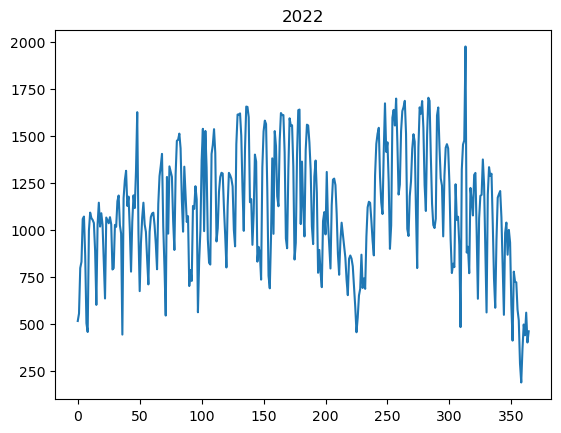

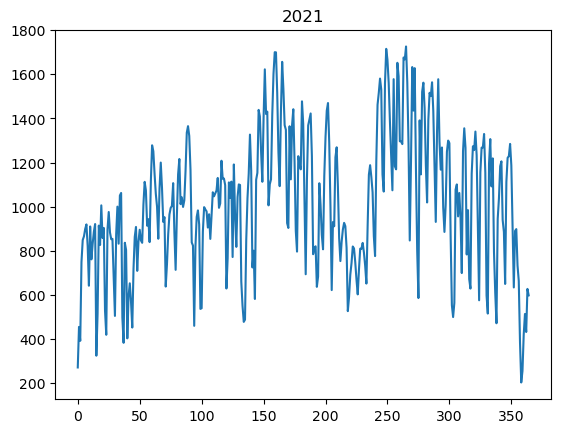

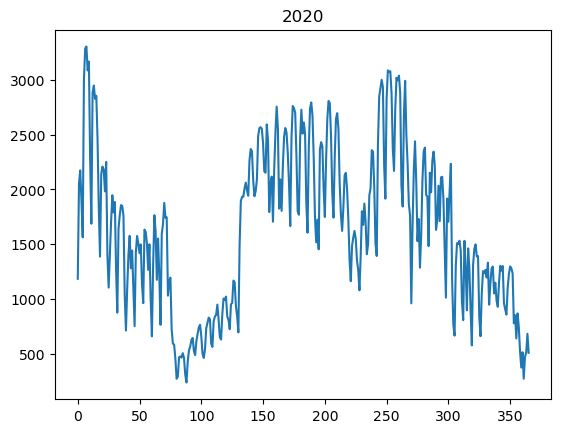

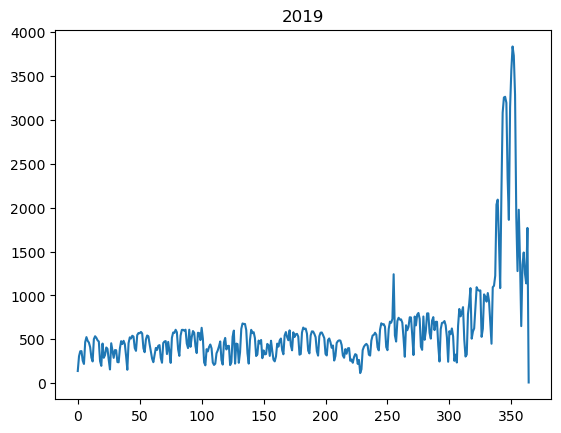

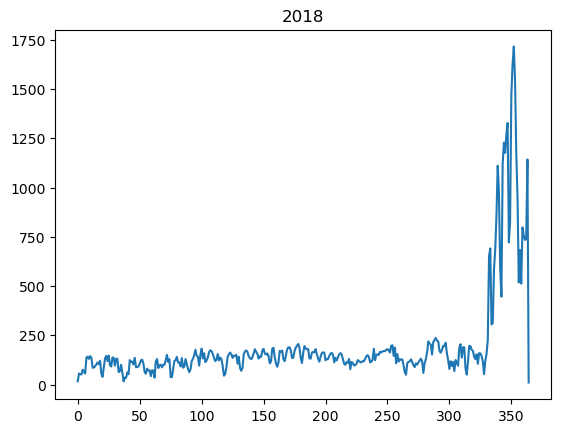

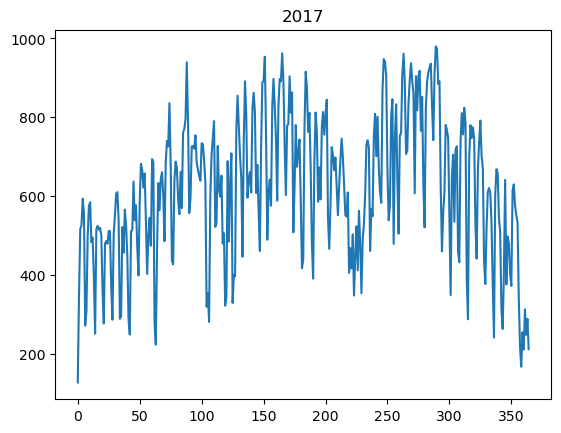

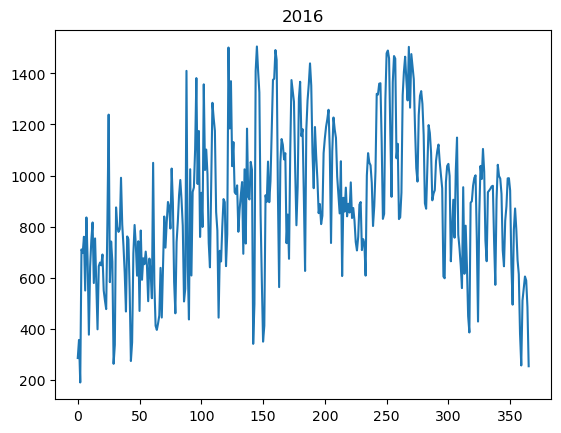

In [47]:
for year,(yeardata,_) in zip(range(2022,2015,-1),all_years):
    plt.plot(range(len(yeardata)),yeardata['mean'])
    plt.title(str(year))
    plt.show()

We can notice the impact of Covid 2019!

In [48]:
pip install nbconvert

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Take the mean of all stations.

In [33]:
yearly_datasets = []
only_mean_yearly = []
for i,year in enumerate(range(2016,2023)):
    print(f"processing {year}")
    filemane = f"./bike/res/{year}processed.csv"
    df = pd.read_csv(filemane,index_col='date')
    df.replace(0,np.nan,inplace=True)
    df['mean'] = df.mean(axis=1)
    yearly_datasets.append(df)
    only_mean_yearly.append(yearly_datasets[-1][['mean']])

processing 2016
processing 2017
processing 2018
processing 2019
processing 2020
processing 2021
processing 2022


In [34]:
final_res = pd.concat(only_mean_yearly)

In [35]:
final_res.rename(columns={'mean': 'bike'}, inplace=True)
final_res

,bike
date,
2016-01-01,356.250000
2016-01-02,444.843750
2016-01-03,236.562500
2016-01-04,888.020833
2016-01-05,870.104167
...,...
2022-12-27,520.223438
2022-12-28,460.121977
2022-12-29,586.222953


In [36]:
final_res.to_csv('bike_traffic_paris_2016_2022.csv',index=True)

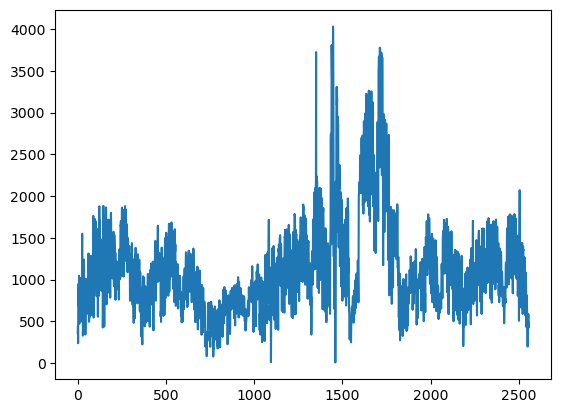

In [38]:
plt.plot(range(len(final_res)),final_res['bike'])